In [ ]:
# Articles
# https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
# https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459
# https://www.machinelearningplus.com/time-series/time-series-analysis-python/

In [215]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.api as sm
import datetime as dt
from pandas.plotting import autocorrelation_plot

In [216]:
data = pd.read_csv("../data/state-daily-stats.csv", parse_dates=['date'])
data.drop(columns={"Unnamed: 0"}, inplace=True)

In [217]:
for index, row in data.iterrows():
    date = dt.datetime.strptime(row["date"], "%Y-%d-%m")
    date2 = dt.datetime.strftime(date, "%m-%d-%Y")
    data.at[index, "date"] = date2

In [218]:
data["date"] = pd.to_datetime(data["date"])
daily_new_cases = pd.DataFrame(data[["date","daily_new_cases"]])
# daily_new_cases.set_index("date", inplace=True)

In [219]:
daily_new_cases = daily_new_cases[daily_new_cases["date"] >= dt.datetime(2020,3,1)]
for index, row in daily_new_cases.iterrows():
    date = row["date"]
    new_date = dt.datetime.strftime(date, "%m-%d-%Y")
    daily_new_cases.at[index, "date"] = new_date

In [220]:
daily_new_cases.set_index("date", inplace=True)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

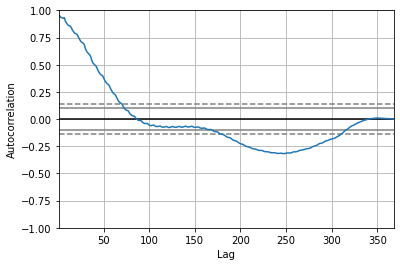

In [221]:
autocorrelation_plot(daily_new_cases)

In [222]:
log_daily_new_cases = pd.DataFrame(np.log(daily_new_cases.daily_new_cases))

<AxesSubplot:xlabel='date'>

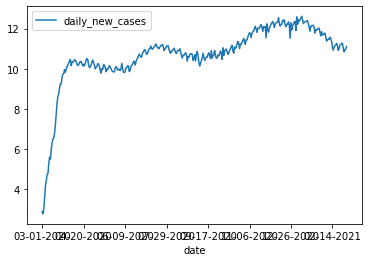

In [223]:
log_daily_new_cases.plot()

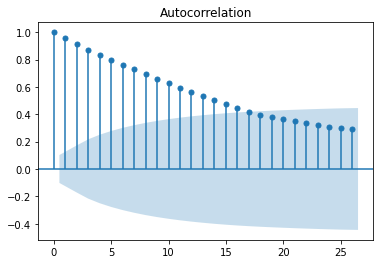

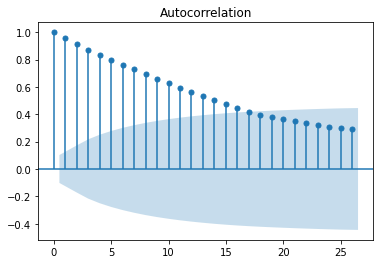

In [224]:
plot_acf(log_daily_new_cases)

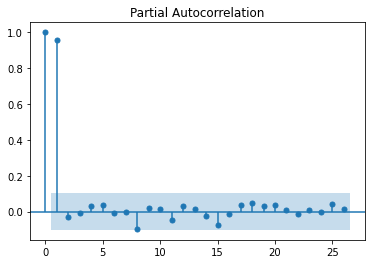

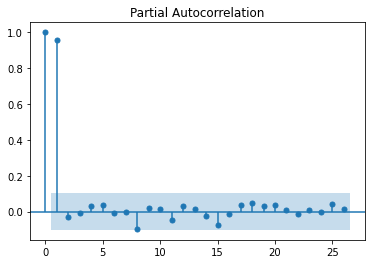

In [225]:
plot_pacf(log_daily_new_cases)

In [226]:
result = adfuller(log_daily_new_cases.daily_new_cases, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -3.3142798774658093
p-value: 0.014252105910300359


In [231]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

model = ARIMA(log_daily_new_cases.daily_new_cases, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:      D.daily_new_cases   No. Observations:                  367
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 122.337
Method:                       css-mle   S.D. of innovations              0.173
Date:                Fri, 05 Mar 2021   AIC                           -234.674
Time:                        14:15:26   BIC                           -215.148
Sample:                    03-02-2020   HQIC                          -226.916
                         - 03-03-2021                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0683      0.078      0.878      0.380      -0.084       0.221
ar.L1.D.daily_new_cases     0.9928      0.008    118.789      0.000       0.976       1.009


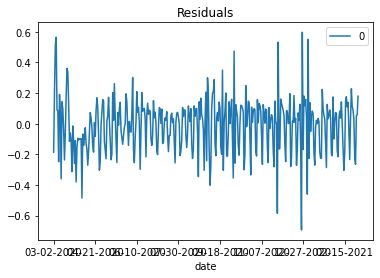

In [232]:
residuals = pd.DataFrame(model_fit.resid)
# fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals")
# residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

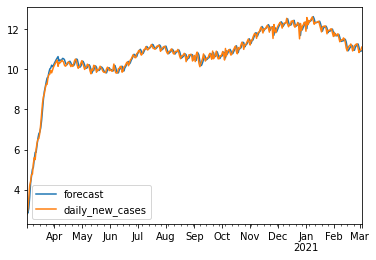

In [233]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [234]:
training = log_daily_new_cases[:276]
testing = log_daily_new_cases[276:]

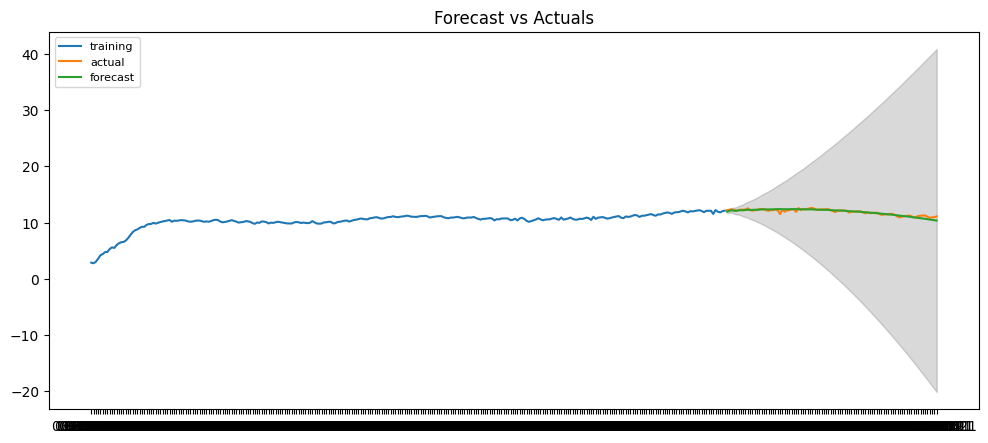

In [235]:
model = ARIMA(training, order=(5, 2, 2))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(92, alpha=0.05)  

# Forecast
# fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=testing.index)
lower_series = pd.Series(conf[:, 0], index=testing.index)
upper_series = pd.Series(conf[:, 1], index=testing.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(training, label='training')
plt.plot(testing, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [236]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D2.daily_new_cases   No. Observations:                  274
Model:                 ARIMA(5, 2, 2)   Log Likelihood                 146.914
Method:                       css-mle   S.D. of innovations              0.140
Date:                Fri, 05 Mar 2021   AIC                           -275.829
Time:                        14:16:15   BIC                           -243.311
Sample:                    03-03-2020   HQIC                          -262.777
                         - 12-01-2020                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0010      0.002     -0.538      0.591      -0.004       0.003
ar.L1.D2.daily_new_cases    -0.0122      0.060     -0.205      0.838      -0.129       0.105
ar.L2.D2.daily_new_cases    -0.4972      0.049    -10.080      0.000      -0.594      -0.401
ar.L3.D2.daily_new_cases    -0.4459      0.049     -9.064      0.000      -0.542      -0.349
ar.L4.D2.daily_new_cases    -0.3896      0.048     -8.201      0.000      -0.483      -0.296
ar.L5.D2.daily_new_cases    -0.5128      0.058     -8.858      0.000      -0.626      -0.399
ma.L1.D2.daily_new_cases    -1.2095      0.038    -31.763      0.000      -1.284      -1.135
ma.L2.D2.daily_new_cases     0.8111      0.053     15.422      0.000       0.708       0.914
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6285           -0.7897j            1.0093           -0.1430
AR.2            0.6285           +0.7897j            1.0093            0.1430
AR.3           -1.3108           -0.0000j            1.3108           -0.5000
AR.4           -0.3530           -1.1558j            1.2085           -0.2972
AR.5           -0.3530           +1.1558j            1.2085            0.2972
MA.1            0.7455           -0.8228j            1.1103           -0.1328
MA.2            0.7455           +0.8228j            1.1103            0.1328
-----------------------------------------------------------------------------
"""

In [237]:
import pmdarima as pm

In [256]:
model = pm.auto_arima(daily_new_cases.daily_new_cases, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8216.793, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8313.872, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8241.484, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8215.014, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8311.903, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8216.789, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8214.316, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8219.962, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8220.194, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=8219.376, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8218.498, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=8212.507, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=8214.597, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : 

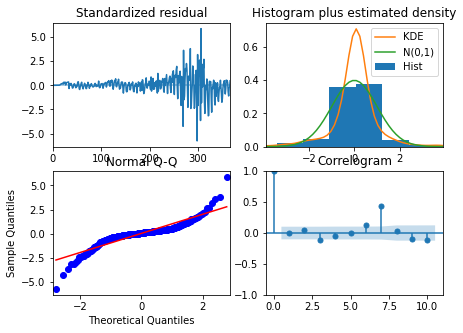

In [257]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [258]:
n_periods = 30
predictions = model.predict(n_periods=n_periods)
predictions

array([63188.69322324, 61696.60805811, 63053.18297596, 61819.81134895,
       62941.16893141, 61921.6523476 , 62848.57706896, 62005.83507466,
       62772.03976485, 62075.42130838, 62708.77330962, 62132.94194347,
       62656.47666286, 62180.48904128, 62613.24776292, 62219.79191939,
       62577.51434777, 62252.28004799, 62547.97677082, 62279.13504057,
       62523.56073198, 62301.33362993, 62503.3782047 , 62319.68319263,
       62486.69513788, 62334.85111369, 62472.90475798, 62347.38905986,
       62461.50550029, 62357.75304405])

In [259]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(daily_new_cases.daily_new_cases, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=8448.755, Time=0.15 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=8194.079, Time=0.29 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=8342.983, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=8448.404, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=8257.933, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=8146.013, Time=1.20 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=8134.393, Time=1.73 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=8128.346, Time=2.24 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=2.48 sec
 ARIMA(2,0,0)(2,1,2)[12] intercept   : AIC=8078.115, Time=2.87 sec
 ARIMA(2,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=8

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  368
Model:             SARIMAX(3, 0, 3)x(2, 1, [1, 2], 12)   Log Likelihood               -4020.289
Date:                                 Fri, 05 Mar 2021   AIC                           8062.579
Time:                                         14:29:01   BIC                           8105.203
Sample:                                              0   HQIC                          8079.534
                                                 - 368                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7225      0.098      7.402      0.000       0.531       0.914
ar.L2         -0.6247      0.117     -5.319      0.000      -0.855      -0.395
ar.L3          0.8887      0.085     10.491      0.000       0.723       1.055
ma.L1         -0.3141      0.116     -2.712      0.007      -0.541      -0.087
ma.L2          0.8221      0.094      8.760      0.000       0.638       1.006
ma.L3         -0.4520      0.095     -4.736      0.000      -0.639      -0.265
ar.S.L12      -0.6410      0.409     -1.568      0.117      -1.442       0.160
ar.S.L24      -0.1889      0.106     -1.784      0.074      -0.397       0.019
ma.S.L12      -0.2351      0.385     -0.611      0.541      -0.989       0.519
ma.S.L24      -0.5235      0.409     -1.280      0.201      -1.325       0.278
sigma2      6.008e+08   3.25e-09   1.85e+17      0.000    6.01e+08    6.01e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):               930.88
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):              54.77   Skew:                            -1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.32e+33. Standard errors may be unstable.
"""

In [265]:
n_periods = 365
predictions_seasonal = smodel.predict(n_periods=n_periods)
predictions_seasonal

array([ 6.49344860e+04,  7.54640631e+04,  6.34237496e+04,  5.63035876e+04,
        6.84607784e+04,  7.38807580e+04,  6.67439086e+04,  6.36576686e+04,
        6.79634453e+04,  6.35996303e+04,  4.99736476e+04,  6.43413707e+04,
        6.11931473e+04,  6.37070485e+04,  5.37890717e+04,  4.63700102e+04,
        6.30604667e+04,  5.68939748e+04,  5.54484605e+04,  5.33073448e+04,
        5.54197603e+04,  5.10264896e+04,  4.44594225e+04,  6.27568153e+04,
        5.33701381e+04,  5.77270183e+04,  5.22817514e+04,  4.68191475e+04,
        5.69245197e+04,  6.01793927e+04,  5.76383680e+04,  5.02700856e+04,
        5.04829911e+04,  5.02322006e+04,  4.16813424e+04,  5.46337262e+04,
        5.03254754e+04,  5.65141959e+04,  4.67735329e+04,  3.91640971e+04,
        5.39221079e+04,  5.39371840e+04,  4.98163128e+04,  4.55114170e+04,
        4.85741947e+04,  4.55489136e+04,  3.59885426e+04,  5.21002588e+04,
        4.65399209e+04,  5.06630241e+04,  4.23457159e+04,  3.64645071e+04,
        4.98259917e+04,  

<AxesSubplot:>

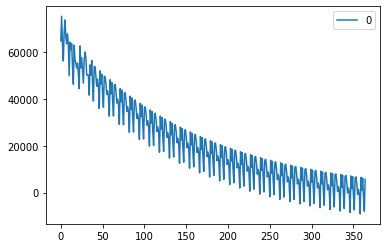

In [266]:
pd.DataFrame(predictions_seasonal).plot()

In [270]:
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(daily_new_cases.daily_new_cases, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(daily_new_cases['daily_new_cases'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()

TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'UnitData'

In [271]:
daily_new_cases

,daily_new_cases
date,
03-01-2020,18
03-02-2020,16
03-03-2020,21
03-04-2020,36
03-05-2020,67
...,...
02-27-2021,62694
02-28-2021,50925
03-01-2021,56672


In [ ]:
result = adfuller(cases_df['cases'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

In [ ]:
df_log = np.log(cases_df)
plt.plot(df_log)

In [ ]:
rolling_mean = df_log.rolling(window=7).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
df_log_minus_mean

In [ ]:
result2 = adfuller(df_log_minus_mean['cases'])
print('ADF Statistic: {}'.format(result2[0]))
print('p-value: {}'.format(result2[1]))
print('Critical Values:')
for key, value in result2[4].items():
    print('\t{}: {}'.format(key, value))

In [ ]:
autocorrelation_plot(df_log_minus_mean)

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(np.log(cases_df.cases), lags=175, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(np.log(cases_df.cases), lags=175, ax=ax[1])
ax[0].set_xlim(0, 177)
ax[1].set_xlim(0, 177)
plt.show()

In [ ]:
sar = sm.tsa.statespace.SARIMAX(np.log(cases_df.cases), 
                                order=(1, 1, 2), 
                                seasonal_order=(2, 1, 1, 7)).fit(max_iter = 50, method = 'powell')
sar.summary()
# SARIMA(1, 1, 2),(2, 1, 1, 7)

In [ ]:
sar = sm.tsa.statespace.SARIMAX(np.log(cases_df.cases), 
                                order=(1, 1, 2), 
                                seasonal_order=(2, 1, 1, 7)).fit(max_iter = 50, method = 'powell')
sar.summary()
# SARIMA(1, 1, 2),(2, 1, 1, 7)

In [ ]:

# res = sar.resid
# fig,ax = plt.subplots(2,1,figsize=(15,8))
# fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
# fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
# ax[0].set_xlim(0, 52)
# ax[1].set_xlim(0, 52)
# plt.show()

In [ ]:
# import itertools

# # set parameter range
# p = range(0,3)
# q = range(1,3)
# d = range(1,2)
# s = range(7,8)

# # list of all parameter combos
# pdq = list(itertools.product(p, d, q))
# # same for seasonal variant
# seasonal_pdq = list(itertools.product(p, d, q, s))

In [ ]:
# import warnings
# warnings.filterwarnings("ignore") # specify to ignore warning messages

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(np.log(cases_df.cases),
#                                             order=param,
#                                             seasonal_order=param_seasonal)
#             results = mod.fit(max_iter = 50, method = 'powell')
            
#             print('----------------------------------------------------------------')
#             print('SARIMA{},{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
#             print('----------------------------------------------------------------')
#         except:
#             continue

In [ ]:
predictions = sar.get_forecast(steps = 30)

In [ ]:
predictions.plot()

# OLD

In [ ]:
for index, row in data.iterrows():
    date = dt.datetime.strptime(row["date"], "%Y-%d-%m")
    date2 = dt.datetime.strftime(date, "%m-%d-%Y")
    data.at[index, "date"] = date2

In [ ]:
# data["date"] = pd.to_datetime(data["date"])

In [ ]:
data.info()

In [ ]:
cases_df = data[["date", "cases"]]

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(cases_df)

In [ ]:
training = data[data["date"] < "2021-02-01"]
training["date_index"] = training["date"]

In [ ]:
training.set_index("date_index", inplace=True)

In [ ]:
plt.figure(figsize=[21,7])
plt.plot(training['cases'])

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(np.log(training.cases), lags=170, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(np.log(training.cases), lags=170, ax=ax[1])
ax[0].set_xlim(0, 177)
ax[1].set_xlim(0, 177)
plt.show()

In [ ]:
training_seas = training.cases.diff(7)
training_diff = training.cases.diff()
training_both = training_seas.diff()

In [ ]:
training_both.fillna(0, inplace=True)

In [ ]:
plt.plot(training_both)

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(training_both)

In [ ]:
pvalue

In [ ]:
test[-10:]

In [ ]:
test_log = np.log(test)
test.plot()

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(np.log(data.cases), lags=175, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(np.log(data.cases), lags=175, ax=ax[1])
ax[0].set_xlim(0, 177)
ax[1].set_xlim(0, 177)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(train_both[8:])

In [ ]:
train2_seas = train2.meter_reading_scraped.diff(7)
train2_diff = train2.meter_reading_scraped.diff()
train_both = train_seas.diff()

In [ ]:
rolling_mean = test.rolling(window = 12).mean()
rolling_std = test.rolling(window = 12).std()
plt.plot(test, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()